<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/CLIP_cleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# all

In [ ]:
# @title setup
# https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


In [ ]:
# @title model
import numpy as np
import torch
# from pkg_resources import packaging
# print("Torch version:", torch.__version__)
import clip
# clip.available_models()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, preprocess = clip.load("ViT-B/32") # preprocess: normalize intensity using dataset mean and sd then resize and center-crop to conform to the model expects. 
# model.cuda().eval()
model.to(device).eval()
input_resolution = model.visual.input_resolution # 224
context_length = model.context_length # 77
vocab_size = model.vocab_size # 49408
# print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}") # 151,277,313
# clip.tokenize("Hello World!") # case-insensitive tokenizer, padded to become 77 tokens


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 104MiB/s]


In [ ]:
# @title download 10k (old)
# https://drive.google.com/file/d/1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q/view?usp=sharing
!gdown 1NkCNecLpFG3i7bo3Vl9RQSwzBpSRQ29q -O gsv.zip
!unzip /content/gsv.zip -d /content
import shutil
shutil.rmtree('/content/google_street_view/meta_data', ignore_errors=True) # delete the meta_data folder

shutil.rmtree('/content/google_street_view/01/02 Drop (More than 90% Obscured)', ignore_errors=True)
shutil.rmtree('/content/google_street_view/01/03 Drop (Multiple Types of Property)', ignore_errors=True)

# move files # https://www.geeksforgeeks.org/how-to-move-all-files-from-one-directory-to-another-using-python/
source = '/content/google_street_view/01/01 Keep'
destination = '/content/google_street_view/01'
import os
allfiles = os.listdir(source)
for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destination, f)
    shutil.move(src_path, dst_path)

shutil.rmtree('/content/google_street_view/01/01 Keep', ignore_errors=True)


In [ ]:
# @title download 70k

# https://drive.google.com/file/d/1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8/view?usp=share_link
!gdown 1-7ZC29k4VxXQkpnOuLfj7Ag_SFTM4LV8 -O gsv.zip
!unzip /content/gsv.zip -d /


In [ ]:
# @title data
from torchvision import datasets#, transforms

# dir='/content/google_street_view'
dir='/content/gsv70k'

# data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)


In [ ]:
# @title test texts
images=[]
og_img=[]

c=30
for i in range(c,c+10):
    img,label=data[i]
    images.append(preprocess(img))
    og_img.append(img)

# 21

# blur 7 43 122
# repeat 88-89
# texts=['a clear image of a house','a blurred image','a plain background']
# an image without a house ; 
# texts=['a clear image of a house','an image of a house ','a blurred image','a plain background']
# texts=['a clear image of a house','an image of a wall','an image of trees','an image of a vehicle','a blurred image','a plain background']
# texts=['an image of a house','a house facade','an image of a construction site','a plain background']
texts=['a house','a house facade','a construction site','a plain background']
# housing facade, construction site, house front


# normalize images, tokenize text input, forward pass model to get image text features
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Calculating cosine similarity: normalize features and calculate dot product of each pair.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
# print(similarity)

count = len(texts)

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(og_img):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(og_img) - 0.5])
# plt.ylim([count + 0.5, -2])
plt.ylim([count - 0.5, -1.5]) # bottom, top margin
plt.show()
# plt.title("Cosine similarity between text and image features", size=20)


In [ ]:
# @title base get similarity

images=[]
og_img=[]

c=110
for i in range(c,c+10):
    img,label=data[i]
    images.append(preprocess(img))
    og_img.append(img)

# blur 7 43
# repeat 88-89
texts=['a clear image of a house','an image without a house','a blurred image','a plain background']

# normalize images, tokenize text input, forward pass model to get image text features
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)


with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Calculating cosine similarity: normalize features and calculate dot product of each pair.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

similarity = text_features @ image_features.T
print(similarity)

# blur 0.23



In [ ]:
# @title collect
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# texts=['a clear image of a house','an image without a house','a blurred image','a plain background']
texts=['a clear image of a house','an image of a wall','an image of trees','an image of a vehicle','a blurred image','a plain background']

text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)
with torch.no_grad(): text_features = model.encode_text(text_tokens).float()
text_features /= text_features.norm(dim=-1, keepdim=True)


# img_dir = '/content/google_street_view/06'
img_dir = '/content/gsv70k/06'

sall=[]

t=0
for filename in os.listdir(img_dir):
    # print(filename)
    name = os.path.splitext(filename)[0]
    img_file=os.path.join(img_dir, filename)
    image = Image.open(img_file).convert("RGB")
   
    img= preprocess(image).to(device).unsqueeze(0)

    with torch.no_grad():
        image_features = model.encode_image(img).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features @ image_features.T
    # print(similarity.T)

    # plt.figure(figsize=(4, 1.25)) # plt.figure(figsize=(16, 5))
    # plt.imshow(image)
    # plt.show()

    sall.append([img_file,similarity.squeeze()])

    # t+=1
    # if t >=5: break

# print(sall)


sall 509
good 390
wall 37
obscured 7
blurred 5
missing 0
left 70


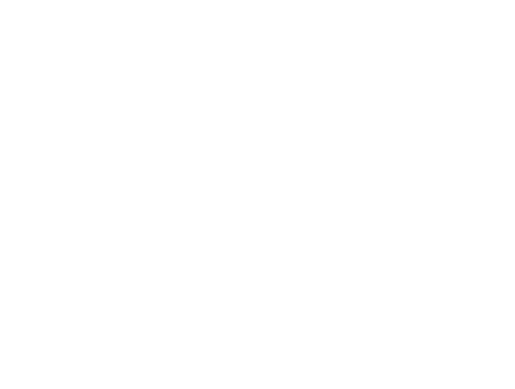

In [ ]:
import torchvision
from torchvision import transforms
plt.axis('off')


def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (16,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def file2img(img_files):
    imgs=[]
    for img_file in img_files:
        image = Image.open(img_file).convert("RGB")
        image=transforms.ToTensor()(image)
        imgs.append(image)
    return imgs

good, wall, obscured, blurred, missing, left = [],[],[],[],[],[]
good_s, wall_s, obscured_s, blurred_s, missing_s, left_s = [],[],[],[],[],[]


t=0
for img_file, similarity in sall:
    # print(img_file, similarity)
    if similarity[1]>=0.23: # wall
        wall.append(img_file)
        wall_s.append(similarity)
    elif similarity[0]<0.23: # obscured?
        obscured.append(img_file)
        obscured_s.append(similarity)
    elif similarity[-2]>=0.23: # blur
        blurred.append(img_file)
        blurred_s.append(similarity)
    elif similarity[-1]>=0.23: # missing
        missing.append(img_file)
        missing_s.append(similarity)
    elif similarity[1:].sum()-similarity[0]>=0.75: #0.75
        left.append(img_file)
        left_s.append(similarity)
    else:
        good.append(img_file)
        good_s.append(similarity)
    # print(similarity[1:].sum()-similarity[0])
    # t+=1
    # if t >=5: break



print("sall",len(sall))
print("good",len(good))
print("wall",len(wall))
print("obscured",len(obscured))
print("blurred",len(blurred))
print("missing",len(missing))
print("left",len(left))

c=0
# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))
# imshow(torchvision.utils.make_grid(file2img(wall),nrow=8))
# imshow(torchvision.utils.make_grid(file2img(obscured),nrow=6))
# imshow(torchvision.utils.make_grid(file2img(blurred),nrow=5))
# imshow(torchvision.utils.make_grid(file2img(missing),nrow=5))




In [ ]:
c=128

def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (20,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))

# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))
# imshow(torchvision.utils.make_grid(file2img(wall),nrow=8))
imshow(torchvision.utils.make_grid(file2img(obscured),nrow=6))
# imshow(torchvision.utils.make_grid(file2img(blurred),nrow=6))
# imshow(torchvision.utils.make_grid(file2img(left),nrow=7))


In [ ]:
print(left_s)

[tensor([0.2588, 0.2153, 0.2204, 0.1922, 0.2036, 0.1981], device='cuda:0'), tensor([0.2622, 0.2066, 0.2095, 0.1831, 0.2175, 0.2039], device='cuda:0'), tensor([0.2368, 0.2295, 0.1959, 0.1861, 0.1971, 0.1988], device='cuda:0'), tensor([0.2632, 0.2237, 0.1719, 0.2090, 0.2146, 0.1990], device='cuda:0'), tensor([0.2475, 0.2091, 0.2055, 0.1842, 0.2139, 0.1887], device='cuda:0'), tensor([0.2735, 0.2111, 0.2127, 0.2035, 0.2118, 0.1952], device='cuda:0'), tensor([0.2473, 0.2092, 0.1994, 0.1879, 0.2120, 0.2006], device='cuda:0'), tensor([0.2725, 0.2243, 0.2244, 0.2021, 0.2206, 0.2066], device='cuda:0'), tensor([0.2566, 0.2152, 0.1986, 0.1996, 0.2087, 0.1870], device='cuda:0'), tensor([0.2710, 0.2086, 0.2057, 0.2141, 0.2058, 0.1955], device='cuda:0'), tensor([0.2617, 0.2294, 0.2168, 0.2003, 0.2072, 0.1885], device='cuda:0'), tensor([0.2557, 0.2176, 0.2092, 0.1921, 0.1966, 0.1934], device='cuda:0'), tensor([0.2471, 0.2273, 0.2330, 0.1875, 0.1929, 0.1968], device='cuda:0'), tensor([0.2473, 0.2198, 

In [ ]:
# for i, sim in enumerate(good_s):
# for i, sim in enumerate(left_s):
for i, sim in enumerate(obscured_s):
    print(i,sim,(sim.sum()-2*sim[0]).item())

# print(good)
# 03: 1 10


0 tensor([0.2214, 0.1867, 0.1565, 0.1612, 0.1726, 0.1734], device='cuda:0') 0.6290048360824585
1 tensor([0.2256, 0.1897, 0.1587, 0.1773, 0.1925, 0.1811], device='cuda:0') 0.6736514568328857
2 tensor([0.2049, 0.1858, 0.1894, 0.2476, 0.2446, 0.2017], device='cuda:0') 0.8641936182975769
3 tensor([0.2267, 0.2196, 0.1786, 0.1757, 0.1903, 0.1963], device='cuda:0') 0.7339578866958618
4 tensor([0.2266, 0.2054, 0.1888, 0.1912, 0.1909, 0.1855], device='cuda:0') 0.7351117134094238
5 tensor([0.2262, 0.1826, 0.1909, 0.1690, 0.2029, 0.1815], device='cuda:0') 0.7005547285079956
6 tensor([0.2134, 0.2035, 0.1879, 0.1738, 0.2099, 0.2107], device='cuda:0') 0.7725209593772888


In [ ]:
# shutil.rmtree('/content/gsv/02/', ignore_errors=True)

allfiles = os.listdir('/content/gsv/06/')
print(len(allfiles))


381


In [ ]:

import os
import shutil

# allfiles = os.listdir(source)
# for f in allfiles:
#     src_path = os.path.join(source, f)
#     dst_path = os.path.join(destination, f)
#     shutil.copyfile(src_path, dst_path)

source = '/content/google_street_view/06/'
destination = '/content/gsv/06'
c=0
for src_path in good:
    f=src_path.split('/')[-1]
    # print('/'.split(name))
    # print(destination, f)
    dst_path = os.path.join(destination, f)
    shutil.copyfile(src_path, dst_path)
    # print(src_path, dst_path)
    # c+=1
    # if c>5: break




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -a /content/gsv
# !rm -R /content/gsv/.ipynb_checkpoints
# %cd /content
!ls
# !zip -r /content/drive/MyDrive/gsv/gsv_clip.zip /content/gsv


.  ..  01  02  03  04  05  06
drive  google_street_view  gsv	gsv_clip.zip  gsv.zip  sample_data


In [ ]:
!unzip /content/gsv.zip -d /content
